In [26]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

# might not need these because they're for plotting
from matplotlib import animation, rc
from IPython.display import HTML
from astropy.io import fits

# Simulating sparkle code

## Setting up MagAO-X HCIPy Functions

In [3]:
import sim_sparkle as smsp
reload(smsp)

<module 'sim_sparkle' from '/Users/clever/code/sparkles/sim/sim_sparkle.py'>

In [16]:
# setup MagAO-X system
pupil_grid, pwfs_grid, magellan_aperture = smsp.create_mag_pupil()
deformable_mirror = smsp.create_DM(pupil_grid)
mpwfs, camera = smsp.create_mod_PWFS(pupil_grid, pwfs_grid, n_steps=12)

In [17]:
# wfs
wf = smsp.create_wf(magellan_aperture)
wfs_pywfs = smsp.create_pwfs(mpwfs, wf)
image_ref = smsp.mod_forward_int(wfs_pywfs)

In [6]:
#int mat - this takes a while! (3.5 minutes)
# this code specifically uses a modulated pyramid
slopes = smsp.create_int_mat_mod(deformable_mirror, wf, mpwfs)

Measure response to mode 1 / 2500
Measure response to mode 11 / 2500
Measure response to mode 21 / 2500
Measure response to mode 31 / 2500
Measure response to mode 41 / 2500
Measure response to mode 51 / 2500
Measure response to mode 61 / 2500
Measure response to mode 71 / 2500
Measure response to mode 81 / 2500
Measure response to mode 91 / 2500
Measure response to mode 101 / 2500
Measure response to mode 111 / 2500
Measure response to mode 121 / 2500
Measure response to mode 131 / 2500
Measure response to mode 141 / 2500
Measure response to mode 151 / 2500
Measure response to mode 161 / 2500
Measure response to mode 171 / 2500
Measure response to mode 181 / 2500
Measure response to mode 191 / 2500
Measure response to mode 201 / 2500
Measure response to mode 211 / 2500
Measure response to mode 221 / 2500
Measure response to mode 231 / 2500
Measure response to mode 241 / 2500
Measure response to mode 251 / 2500
Measure response to mode 261 / 2500
Measure response to mode 271 / 2500
Mea

In [7]:
# the reconstrunction matrix for 
ret_mat = smsp.create_recon_mat(slopes)

## test sparkle generations

In [8]:
sparks_list = smsp.genSpark(seperation=20, angleOff=0.0, amp = 0.02) # takes in specific params, will iter on this

In [20]:
# test a propagation
focal_grid = make_focal_grid(q=8, num_airy=20, spatial_resolution=smsp.spatial_resolution)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
norm = prop(wf).power.max()

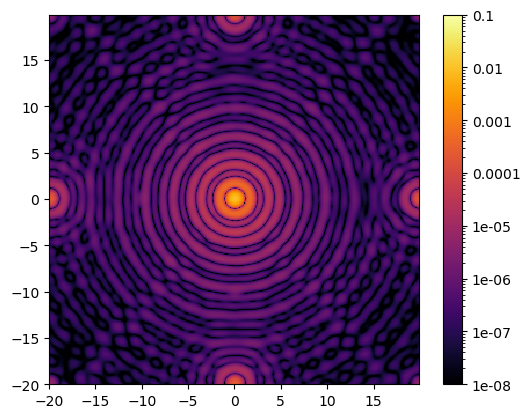

In [23]:
#set the DM to sparkles:
deformable_mirror.actuators = sparks_list[0]

# Wavront on the DM
wf_dm = deformable_mirror.forward(wf)
# Wavefront on the pyramid WFS
wf_pyr = mpwfs.forward(wf_dm)
# Integrated image on the pywfs
wfs_image = smsp.mod_forward_int(wf_pyr)


# PSF: science return of interest
psf = prop(deformable_mirror(wf)).power

imshow_psf(psf, spatial_resolution=smsp.spatial_resolution)
plt.show()

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [47]:
def create_sparkle_animation():
    deformable_mirror.flatten()
    PSF = prop(deformable_mirror(wf)).power

    fig = plt.figure(figsize=(9,3))

    ax1 = plt.subplot(1,3,1)
    plt.title(r'DM surface ($\mathrm{\mu}$m)')
    im1 = imshow_field(deformable_mirror.surface/(1e-6), vmin=-0.3, vmax=0.3, cmap='bone')
    #plt.colorbar()
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    ax2 = plt.subplot(1,3,2)
    plt.title('PyWFS')
    im2 = imshow_field(image_ref, pwfs_grid)
    #plt.colorbar()
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    ax3 = plt.subplot(1,3,3)
    plt.title('Science Image')
    im3 = imshow_field(np.log10(PSF / norm), vmax=0, vmin=-5, cmap='inferno')
    #plt.colorbar()
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    fig.tight_layout()

    plt.close(fig)

    def animate(t):
        sparks_list = smsp.genSpark(seperation=t, angleOff=t*20/360, amp = 0.02) # takes in specific params, will iter on this
        #set the DM to sparkles:
        deformable_mirror.actuators = sparks_list[0]

        wf_dm = deformable_mirror.forward(wf)
        wf_pyr = mpwfs.forward(wf_dm)

        wfs_image = smsp.mod_forward_int(wf_pyr)

        #diff_image = wfs_image - image_ref
        #deformable_mirror.actuators = (1-leakage) * deformable_mirror.actuators - gain * reconstruction_matrix.dot(diff_image)

        #phase = magellan_aperture * deformable_mirror.surface
        #phase -= np.mean(phase[magellan_aperture>0])

        psf = prop(deformable_mirror(wf)).power

        im1.set_data(*pupil_grid.separated_coords, (magellan_aperture * deformable_mirror.surface).shaped / 1e-6)
        im2.set_data(*pwfs_grid.separated_coords, wfs_image.shaped)
        im3.set_data(*focal_grid.separated_coords, np.log10(psf.shaped / norm))

        return [im1, im2, im3]

    num_time_steps=22
    time_steps = np.arange(num_time_steps)
    anim = animation.FuncAnimation(fig, animate, time_steps, interval=160, blit=True)
    anim.save('spark_twirl.gif')
    return HTML(anim.to_jshtml(default_mode='loop'))

create_sparkle_animation()

MovieWriter ffmpeg unavailable; using Pillow instead.


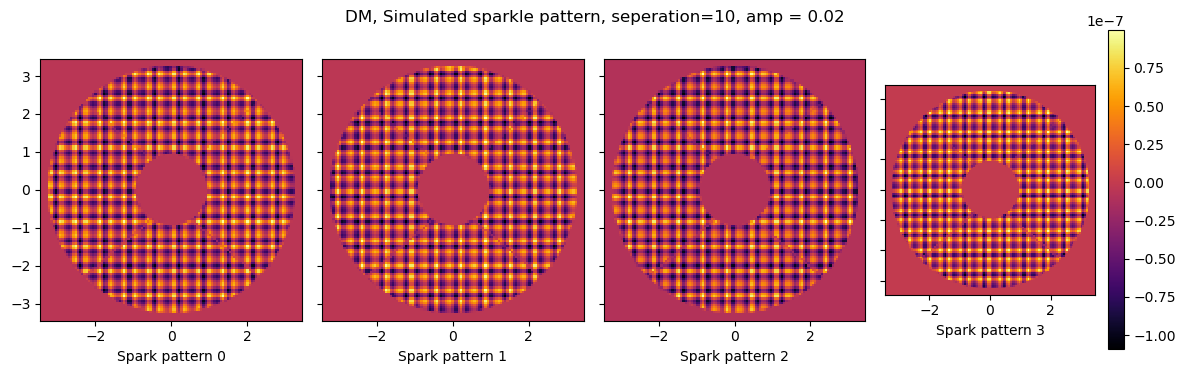

In [44]:
# plotting all the sparkle patterns just to see
# is there an easy way for me to propagate them to the pywfs? showing delay?'
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4), facecolor='white', sharey=True)
fig.subplots_adjust(wspace=0)
plt.suptitle(f"DM, Simulated sparkle pattern, seperation=10, amp = 0.02", y=0.90)

for e in range(4):
    plt.sca(axs[e])  
    deformable_mirror.actuators = sparks_list[e]
    imshow_field(magellan_aperture * deformable_mirror.opd, cmap='inferno', label = f'ref {e}', interpolation="nearest")
    plt.xlabel(f"Spark pattern {e}")
plt.colorbar()
plt.tight_layout()
plt.show()


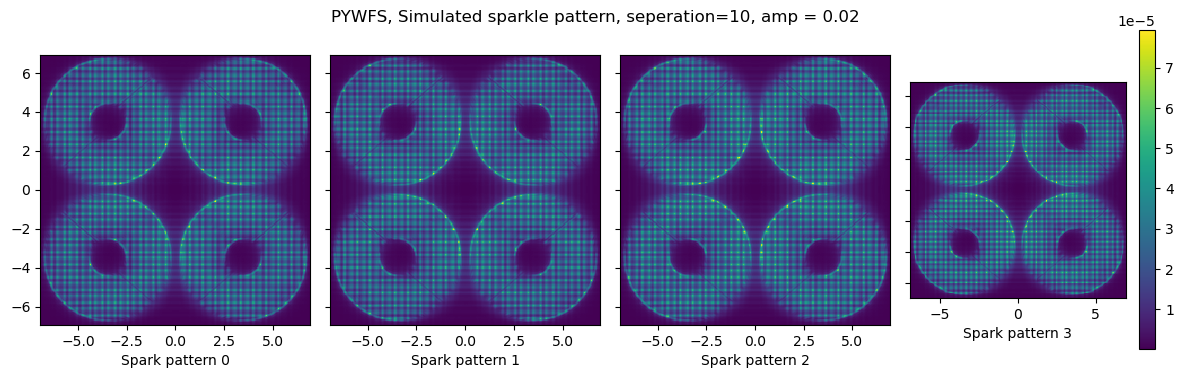

In [10]:
# Plotting the sparkle patterns after propagating to the PYWFS
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4), facecolor='white', sharey=True)
fig.subplots_adjust(wspace=0)
plt.suptitle(f"PYWFS, Simulated sparkle pattern, seperation=10, amp = 0.02", y=0.90)

for e in range(4):
    plt.sca(axs[e]) 
    #propagating the specific sparkle pattern 
    deformable_mirror.actuators = sparks_list[e]
    dm_wf = deformable_mirror.forward(wf)
    mwfs_wf = mpwfs.forward(dm_wf)
    wfs_image = smsp.mod_forward_int(mwfs_wf)
    #now showing the pywfs image
    imshow_field(wfs_image, pwfs_grid, cmap='viridis', label = f'ref {e}', interpolation="nearest")
    plt.xlabel(f"Spark pattern {e}")
plt.colorbar()
plt.tight_layout()
plt.show()

In [14]:

focal_grid = make_focal_grid(q=8, num_airy=20, spatial_resolution=smsp.spatial_resolution)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

PSF_in = prop(wfs_image).power
imshow_psf(PSF_in, spatial_resolution=smsp.spatial_resolution)
plt.show()

AttributeError: 'OldStyleField' object has no attribute 'wavelength'

# sparkle propagation gif